In [3]:
import numpy as np
import os
import netCDF4 as nc

In [2]:
spcam_data_path = "/Volumes/data_backup/experience_replay_data/spcam/nc_files/"
nncam_data_path = "/Volumes/data_backup/experience_replay_data/nncam/nc_files/"

In [4]:
sample_data = nc.Dataset(os.path.join(spcam_data_path, "spcam.baseline.cam.h0.1998-01.nc"))

In [7]:
for key in sample_data.variables.keys():
    print(key)

lev
hyam
hybm
ilev
hyai
hybi
P0
time
date
datesec
lat
lon
slat
slon
w_stag
time_bnds
date_written
time_written
ntrm
ntrn
ntrk
ndbase
nsbase
nbdate
nbsec
mdt
nlon
wnummax
gw
ndcur
nscur
co2vmr
ch4vmr
n2ovmr
f11vmr
f12vmr
sol_tsi
nsteph
ABSORB
AEROD_v
ANRAIN
ANSNOW
AOD400
AOD700
AODABS
AODDUST1
AODDUST2
AODDUST3
AODMODE1
AODMODE2
AODMODE3
AODVIS
AQRAIN
AQSNOW
AQSO4_H2O2_EP
AQSO4_O3_EP
AREI
AREL
ATMEINT
AWNC
AWNI
BFLX
BURDEN1
BURDEN2
BURDEN3
BURDENBC
BURDENDUST
BURDENPOM
BURDENSEASALT
BURDENSO4
BURDENSOA
CAPE
CCN3
CDNUMC
CLDFSNOW
CLDHGH
CLDICE
CLDLIQ
CLDLOW
CLDMED
CLDTOT
CLOUD
CLOUDTOP
CMFDQ
CMFDQR
CMFDT
CMFMC
CMFMCDZM
CONCLD
CRM_DD
CRM_DU
CRM_ED
CRM_EU
CRM_MD
CRM_MU
DCQ
DMS
DMSACHEM_EP
DMSACT_EP
DMSCONV_EP
DMSEP
DMSRENM_EP
DMSSFACHDN_EP
DMSSFACHEM_EP
DMSSFACHQU_EP
DMSSFACHUP_EP
DMSSFACTDN_EP
DMSSFACTQU_EP
DMSSFACTUP_EP
DMSSFACT_EP
DMSSFCONDN_EP
DMSSFCONQU_EP
DMSSFCONUP_EP
DMSSFCONV_EP
DMSSFEP
DMSSFREMDN_EP
DMSSFREMQU_EP
DMSSFREMUP_EP
DMSSFRENM_EP
DMSSFRESDN_EP
DMSSFRESQU_EP
DMSSFRESUP_EP

In [8]:
sample_data.variables["TREFHT"]

<class 'netCDF4._netCDF4.Variable'>
float32 TREFHT(time, lat, lon)
    units: K
    long_name: Reference height temperature
    cell_methods: time: mean
unlimited dimensions: time
current shape = (1, 96, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [9]:
def get_t2m(data_file):
    data = nc.Dataset(data_file)
    return data.variables["TREFHT"]

In [16]:
def area_RMSE(model, obs, lat):
    '''
    calculate weighted area RMSE
    input data is numpy array
    model and obs should have shape (lat, lon)
    '''
    # Calculate weights based on latitude
    weights = np.cos(np.deg2rad(lat))
    
    # Expand weights to match data dimensions
    weights = weights[:, np.newaxis]
    
    # Calculate squared difference
    bias_2 = (model - obs) ** 2
    
    # Apply weights and take mean
    bias_2_weighted = bias_2 * weights
    bias_2_mean = np.sum(bias_2_weighted) / np.sum(weights)
    
    return np.sqrt(bias_2_mean)

In [17]:
spcam_t2m = get_t2m(os.path.join(spcam_data_path, "spcam.baseline.cam.h0.1998-01.nc"))[:]
nncam_t2m = get_t2m(os.path.join(nncam_data_path, "conv_mem_share3.cam.h0.1998-01.nc"))[:]
nncam_rmse = area_RMSE(spcam_t2m, nncam_t2m, sample_data.variables["lat"])


In [18]:
print(nncam_rmse)

46.01050455647999


In [19]:
er_t2m = get_t2m("/Volumes/data_backup/experience_replay_data/er_mix1.0_std/nc_files/conv_mem_spinup5.cam.h0.1998-01.nc")[:]
er_rmse = area_RMSE(spcam_t2m, er_t2m, sample_data.variables["lat"])
print(er_rmse)


43.310810855109914


In [21]:
er_data_path = "/Volumes/data_backup/experience_replay_data/er_mix1.0_std/nc_files/"

In [25]:
# loop through 1998-01 to 1998-12
nncam_rmse_array = []
er_rmse_array = []
for i in range(1,13):
    spcam_t2m = get_t2m(os.path.join(spcam_data_path, f"spcam.baseline.cam.h0.1998-{i:02d}.nc"))[:]
    nncam_t2m = get_t2m(os.path.join(nncam_data_path, f"conv_mem_share3.cam.h0.1998-{i:02d}.nc"))[:]
    er_t2m = get_t2m(os.path.join(er_data_path, f"conv_mem_spinup5.cam.h0.1998-{i:02d}.nc"))[:]
    nncam_rmse = area_RMSE(spcam_t2m, nncam_t2m, sample_data.variables["lat"])
    er_rmse = area_RMSE(spcam_t2m, er_t2m, sample_data.variables["lat"])
    nncam_rmse_array.append(nncam_rmse)
    er_rmse_array.append(er_rmse)

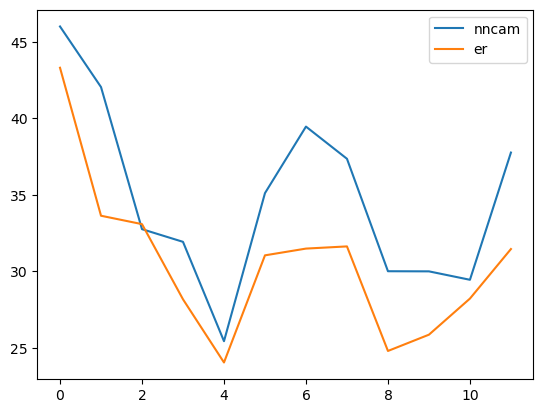

In [27]:
# plot the two array rmse
import matplotlib.pyplot as plt
plt.plot(nncam_rmse_array, label="nncam")
plt.plot(er_rmse_array, label="er")
plt.legend()
plt.show()


In [ ]:
def compute_annual_rmse(spcam_path, model_path):
    """
    Compute monthly RMSE between SPCAM and a model for the year 1998
    
    Parameters:
    -----------
    spcam_path : str
        Path to SPCAM data directory
    model_path : str 
        Path to model data directory
        
    Returns:
    --------
    rmse_array : list
        List of 12 monthly RMSE values
    """
    rmse_array = []
    for i in range(1,13):
        spcam_t2m = get_t2m(os.path.join(spcam_path, f"spcam.baseline.cam.h0.1998-{i:02d}.nc"))[:]
        model_t2m = get_t2m(os.path.join(model_path, f"conv_mem_spinup5.cam.h0.1998-{i:02d}.nc"))[:]
        rmse = area_RMSE(spcam_t2m, model_t2m, sample_data.variables["lat"])
        rmse_array.append(rmse)
    return rmse_array

# Example usage:
nncam_rmse_array = compute_annual_rmse(spcam_data_path, nncam_data_path)
er_rmse_array = compute_annual_rmse(spcam_data_path, er_data_path)
